In [11]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\juanf\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [7]:
ruta = '../data/clean_data/noticias_combinadas.csv'
df = pd.read_csv(ruta)
X = df["text"].astype(str)
y = df["label"].astype(int)
df.head()

,text,label
0,en una rueda de prensa las autoridades dijeron...,True
1,una operacion en la que las autoridades irland...,True
2,el nuevo informe se basa en mas de entrevistas...,True
3,las pruebas hechas a varias de las principales...,True
4,michelle y john wylie estuvieron buscando dura...,True


In [8]:
# funcion generica para stopwords - stemming
spanish_stopwords = stopwords.words("spanish")
stemmer = SnowballStemmer("spanish")

def preprocess(texts, remove_stop=False, apply_stem=False):
    processed = []
    for t in texts:
        tokens = t.split()
        if remove_stop:
            tokens = [w for w in tokens if w not in spanish_stopwords]
        if apply_stem:
            tokens = [stemmer.stem(w) for w in tokens]
        processed.append(" ".join(tokens))
    return processed


In [9]:
# configuraciones cruzadas
configs = [
    ("TO", False, False),
    ("TO", True, False),
    ("TO", False, True),
    ("TO", True, True),
    ("TF-IDF", False, False),
    ("TF-IDF", True, False),
    ("TF-IDF", False, True),
    ("TF-IDF", True, True),
]

models = {
    "Regresion logistica": LogisticRegression(max_iter=1000),
    "Arboles de decision": DecisionTreeClassifier(),
    "K Vecinos": KNeighborsClassifier(),
    "SVM": SVC(kernel="linear")
}

results = []

In [12]:
# entrenar
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

for i, (pond, stop, stem) in enumerate(configs, start=1):
    print(f"Configuracion {i}: {pond}, stop={stop}, stem={stem}")
    
    X_proc = preprocess(X, remove_stop=stop, apply_stem=stem)

    if pond == "TO":
        vectorizer = CountVectorizer()
    else:
        vectorizer = TfidfVectorizer()
        
    X_vec = vectorizer.fit_transform(X_proc)

    for model_name, model in models.items():
        acc_scores, prec_scores, rec_scores, f1_scores = [], [], [], []
        
        for train_idx, test_idx in skf.split(X_vec, y):
            X_train, X_test = X_vec[train_idx], X_vec[test_idx]
            y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
            
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            
            acc_scores.append(accuracy_score(y_test, y_pred))
            prec_scores.append(precision_score(y_test, y_pred))
            rec_scores.append(recall_score(y_test, y_pred))
            f1_scores.append(f1_score(y_test, y_pred))
        
        results.append({
            "#": i,
            "POND": pond,
            "STOPWORDS": stop,
            "STEMMING": stem,
            "ALGORITMO": model_name,
            "Accuracy": np.mean(acc_scores),
            "Precision": np.mean(prec_scores),
            "Recall": np.mean(rec_scores),
            "F1-Score": np.mean(f1_scores)
        })


Configuracion 1: TO, stop=False, stem=False
Configuracion 2: TO, stop=True, stem=False
Configuracion 3: TO, stop=False, stem=True
Configuracion 4: TO, stop=True, stem=True
Configuracion 5: TF-IDF, stop=False, stem=False
Configuracion 6: TF-IDF, stop=True, stem=False
Configuracion 7: TF-IDF, stop=False, stem=True
Configuracion 8: TF-IDF, stop=True, stem=True


In [13]:
results_df = pd.DataFrame(results)
results_df.to_csv("../data/clean_data/resultados_experimentos.csv", index=False)
print(results_df)

    #    POND  STOPWORDS  STEMMING            ALGORITMO  Accuracy  Precision  \
0   1      TO      False     False  Regresion logistica  0.927438   0.928356   
1   1      TO      False     False  Arboles de decision  0.893314   0.896720   
2   1      TO      False     False            K Vecinos  0.691089   0.672382   
3   1      TO      False     False                  SVM  0.924385   0.926844   
4   2      TO       True     False  Regresion logistica  0.921513   0.922725   
5   2      TO       True     False  Arboles de decision  0.889543   0.896245   
6   2      TO       True     False            K Vecinos  0.612065   0.576566   
7   2      TO       True     False                  SVM  0.918102   0.924067   
8   3      TO      False      True  Regresion logistica  0.923667   0.927933   
9   3      TO      False      True  Arboles de decision  0.889909   0.887991   
10  3      TO      False      True            K Vecinos  0.698093   0.681845   
11  3      TO      False      True      

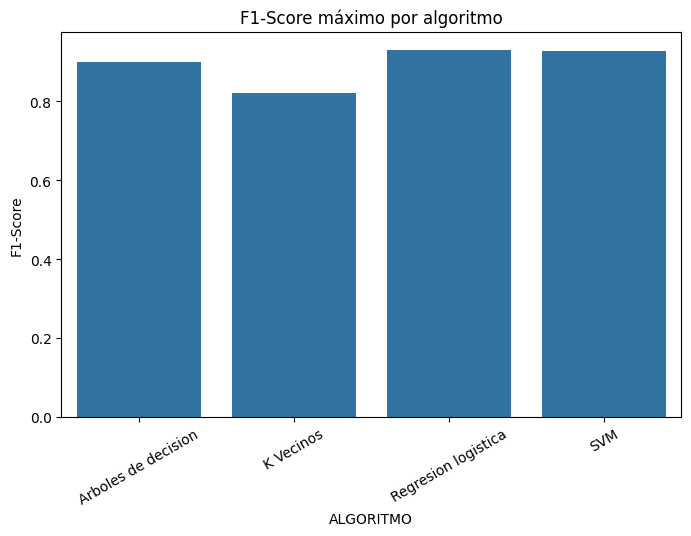

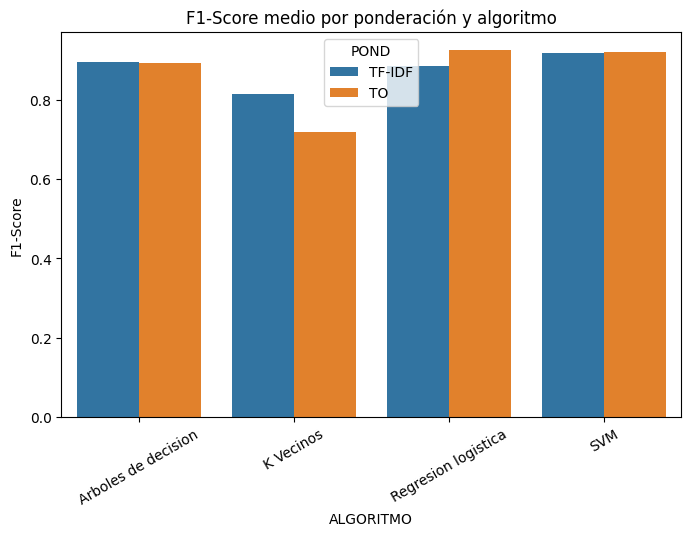

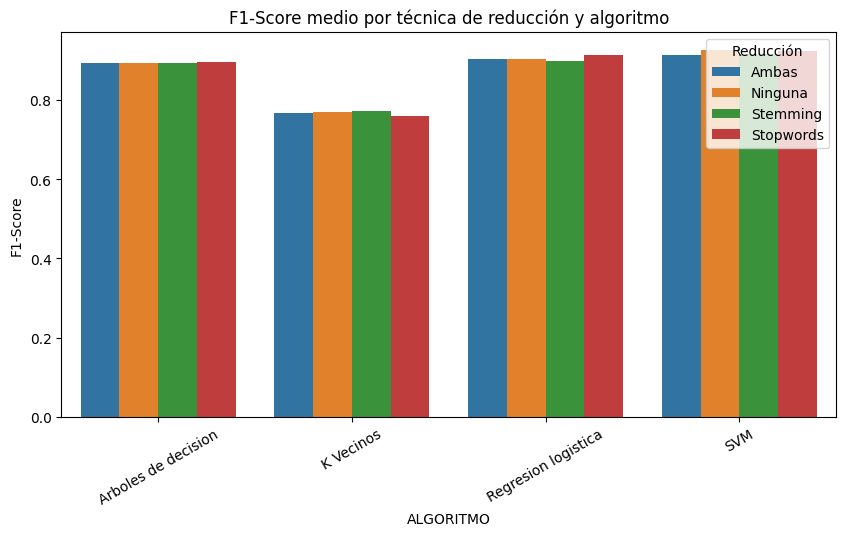

In [14]:
# maximo F1 por algoritmo
plt.figure(figsize=(8,5))
sns.barplot(data=results_df.groupby("ALGORITMO")["F1-Score"].max().reset_index(),
            x="ALGORITMO", y="F1-Score")
plt.title("F1-Score máximo por algoritmo")
plt.xticks(rotation=30)
plt.show()

# promedio F1 por ponderacion y algoritmo
plt.figure(figsize=(8,5))
sns.barplot(data=results_df.groupby(["POND","ALGORITMO"])["F1-Score"].mean().reset_index(),
            x="ALGORITMO", y="F1-Score", hue="POND")
plt.title("F1-Score medio por ponderación y algoritmo")
plt.xticks(rotation=30)
plt.show()

# promedio F1 por tecnica de reduccion y algoritmo
results_df["Reducción"] = results_df.apply(
    lambda r: "Stopwords" if r["STOPWORDS"] and not r["STEMMING"] else
              "Stemming" if r["STEMMING"] and not r["STOPWORDS"] else
              "Ambas" if r["STOPWORDS"] and r["STEMMING"] else
              "Ninguna", axis=1)

plt.figure(figsize=(10,5))
sns.barplot(data=results_df.groupby(["Reducción","ALGORITMO"])["F1-Score"].mean().reset_index(),
            x="ALGORITMO", y="F1-Score", hue="Reducción")
plt.title("F1-Score medio por técnica de reducción y algoritmo")
plt.xticks(rotation=30)
plt.show()